In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import os

%matplotlib inline

## 1. Load Delay Time for all bridges from the simulation data

In [2]:
df_delay = pd.read_csv("ResultsSummary.csv")
df_delay = df_delay[(df_delay["Object Type"] == "Bridge") & (df_delay["Statistic Type"] == "Average (Hours)")]
df_delay = df_delay[(df_delay["Scenario"] != "Scenario1") & (df_delay["Scenario"] != "Scenario8")]
df_delay = df_delay[["Object Name", "Average"]].groupby("Object Name").mean().reset_index()
df_delay.head()

,Object Name,Average
0,Bridge0,0.005976
1,Bridge1,0.001599
2,Bridge10,0.005286
3,Bridge100,0.002546
4,Bridge101,0.001672


In [3]:
# map Object Name (Bridge 0,1,2...) into LRP Name
df_b = pd.read_csv("Road_Bridge_Data.csv")
df_b = df_b[df_b["type"] == "Bridge"][["lrp", "Object Name"]]
m = dict(zip(df_b["Object Name"], df_b["lrp"]))

In [4]:
df_delay["LRPName"] = df_delay["Object Name"].map(m)
df_delay.columns = ['Object Name', 'Delay Time', 'LRPName']
df_delay.head()

,Object Name,Delay Time,LRPName
0,Bridge0,0.005976,LRP001a
1,Bridge1,0.001599,LRP004b
2,Bridge10,0.005286,LRP013a
3,Bridge100,0.002546,LRP172b
4,Bridge101,0.001672,LRP173a


In [5]:
# add delay time data into the entire bridge data
df_b = pd.merge(left = pd.read_csv("cleaned_bridge.csv", index_col = 0),
                right = df_delay, on = "LRPName")
df_b.head()

,index,road,km,type,LRPName,name,length,condition,structureNr,roadName,...,spans,zone,circle,division,sub-division,lat,lon,EstimatedLoc,Object Name,Delay Time
0,0,N1,1.800,Box Culvert,LRP001a,.,11.3,A,117861,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,...,2.0,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.698739,90.458861,interpolate,Bridge0,0.005976
1,1,N1,4.925,Box Culvert,LRP004b,.,6.6,A,117862,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,...,1.0,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.694664,90.487775,interpolate,Bridge1,0.001599
2,12706,N1,8.976,PC Girder Bridge,LRP008b,KANCHPUR PC GIRDER BRIDGE,397.0,C,101102,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,...,8.0,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.705060,90.523214,interpolate,Bridge12706,0.294626
3,14585,N1,10.543,Box Culvert,LRP010a,KATCHPUR BOX CULVERT,8.0,B,101106,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,...,2.0,Dhaka,Dhaka,Narayanganj,Vitikandi,23.696400,90.535099,interpolate,Bridge14585,0.018222
4,3,N1,10.880,Box Culvert,LRP010b,NOYAPARA CULVERT,6.3,A,112531,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,...,2.0,Dhaka,Dhaka,Narayanganj,Vitikandi,23.694391,90.537574,interpolate,Bridge3,0.002454


## 2. Load Traffic Data from HTML

In [6]:
# read traffic data
df_tr = pd.read_csv("N1_traffic.csv", index_col = 0)
# df_tr = df_tr[["Chainage_End", "Total AADT"]]
df_tr["index"] = np.arange(len(df_b), len(df_b) + len(df_tr), 1)
df_tr = df_tr.set_index("index")
df_tr["Section"] = np.arange(1,len(df_tr)+1)
df_tr.columns.values[7] = "chainage"
idx = df_b.index
df_tr.head()

,Link No,Name,LRP_Start,Offset_Start,Chainage_Start,LRP_End,Offset_End,chainage,(Km),Heavy Truck,...,Car,Auto Rickshaw,Motor Cycle,Bi-Cycle,Cycle Rickshaw,Cart,Motorized,Non Motorized,Total AADT,Section
index,,,,,,,,,,,,,,,,,,,,,
630,N1-1L,Jatrabari - Int.with Z1101 (Left) (Left),LRPS,0,0.000,LRPS,822,0.822,0.822,1062,...,4459,5488,834,445,1977,0,38472,2422,40894,1
631,N1-2L,Int.with Z1101 - Signboard (Left) R111 (Left),LRPS,822,0.822,LRPS,4175,4.175,3.353,1062,...,4459,5488,834,445,1977,0,38472,2422,40894,2
632,N1-3L,Signboard - Shimrail (Left)R110 (Left),LRPS,4175,4.175,LRPS,7181,7.181,3.006,176,...,3299,4423,2122,147,2338,0,31733,2485,34218,3
633,N1-4L,Shimrail - Katchpur (Left)N2 (Left),LRPS,7181,7.181,LRP009,260,8.763,1.582,327,...,3527,5847,2305,728,2608,0,31997,3336,35333,4
634,N1-5L,Katchpur - Madanpur (Left)N105 (Left),LRP009,260,8.763,LRP012,439,11.936,3.173,327,...,3684,6234,2297,728,2608,0,45132,3336,48468,5


In [7]:
# concat (row binding) bridge + traffic
df_b = pd.concat([df_b, df_tr]).sort_values("chainage")

# assign Total AADT to bridge rows
df_b["Total AADT"] = df_b["Total AADT"].fillna(method = "bfill")

# assign Section to bridge rows
df_b["Section"] = df_b["Section"].fillna(method = "bfill")

df_b["Section"] = df_b["Section"].apply(lambda x: int(x))
df_b = df_b.loc[idx]

In [8]:
# data frame contains number of bridges in every section
df = df_b.pivot_table(index = "Section",
                      columns = ["condition"],
                      values = "Delay Time", 
                      aggfunc = "count",
                      fill_value = 0).reset_index()
df.head()

condition,Section,A,B,C,D
0,2,1,0,0,0
1,3,1,0,0,0
2,5,3,2,1,0
3,6,5,1,0,0
4,7,3,5,0,0


In [9]:
# add number of bridges (A,B,C,D) to traffic data
df_tr = pd.merge(df_tr, df, on = "Section")
df_tr.head()

,Link No,Name,LRP_Start,Offset_Start,Chainage_Start,LRP_End,Offset_End,chainage,(Km),Heavy Truck,...,Cycle Rickshaw,Cart,Motorized,Non Motorized,Total AADT,Section,A,B,C,D
0,N1-2L,Int.with Z1101 - Signboard (Left) R111 (Left),LRPS,822,0.822,LRPS,4175,4.175,3.353,1062,...,1977,0,38472,2422,40894,2,1,0,0,0
1,N1-3L,Signboard - Shimrail (Left)R110 (Left),LRPS,4175,4.175,LRPS,7181,7.181,3.006,176,...,2338,0,31733,2485,34218,3,1,0,0,0
2,N1-5L,Katchpur - Madanpur (Left)N105 (Left),LRP009,260,8.763,LRP012,439,11.936,3.173,327,...,2608,0,45132,3336,48468,5,3,2,1,0
3,N1-6L,Madanpur - Langalband (Left)Z1061 (Left),LRP012,439,11.936,LRP013,3411,15.935,3.999,327,...,2608,0,45132,3336,48468,6,5,1,0,0
4,N1-7L,Langalband - Mograpara Chowrasta (Left)Z1089 (...,LRP013,3411,15.935,LRP013,7520,20.044,4.109,327,...,2608,0,45132,3336,48468,7,3,5,0,0


In [10]:
# data frame contains Delay Time (caused by bridge) of every section
df = df_b.pivot_table(index = "Section",
                      columns = ["condition"],
                      values = "Delay Time", 
                      aggfunc = "sum",
                      fill_value = 0).reset_index()
df.head()

condition,Section,A,B,C,D
0,2,0.005976,0.000000,0.000000,0.0
1,3,0.001599,0.000000,0.000000,0.0
2,5,0.008168,0.044748,0.294626,0.0
3,6,0.020747,0.008318,0.000000,0.0
4,7,0.030114,0.139343,0.000000,0.0


In [11]:
# add delay time of bridges (A,B,C,D) to traffic data
df_tr = pd.merge(df_tr, df, on = "Section", suffixes = ("_num", "_delay"))
df_tr.head()

,Link No,Name,LRP_Start,Offset_Start,Chainage_Start,LRP_End,Offset_End,chainage,(Km),Heavy Truck,...,Total AADT,Section,A_num,B_num,C_num,D_num,A_delay,B_delay,C_delay,D_delay
0,N1-2L,Int.with Z1101 - Signboard (Left) R111 (Left),LRPS,822,0.822,LRPS,4175,4.175,3.353,1062,...,40894,2,1,0,0,0,0.005976,0.000000,0.000000,0.0
1,N1-3L,Signboard - Shimrail (Left)R110 (Left),LRPS,4175,4.175,LRPS,7181,7.181,3.006,176,...,34218,3,1,0,0,0,0.001599,0.000000,0.000000,0.0
2,N1-5L,Katchpur - Madanpur (Left)N105 (Left),LRP009,260,8.763,LRP012,439,11.936,3.173,327,...,48468,5,3,2,1,0,0.008168,0.044748,0.294626,0.0
3,N1-6L,Madanpur - Langalband (Left)Z1061 (Left),LRP012,439,11.936,LRP013,3411,15.935,3.999,327,...,48468,6,5,1,0,0,0.020747,0.008318,0.000000,0.0
4,N1-7L,Langalband - Mograpara Chowrasta (Left)Z1089 (...,LRP013,3411,15.935,LRP013,7520,20.044,4.109,327,...,48468,7,3,5,0,0,0.030114,0.139343,0.000000,0.0


In [12]:
# add column: sum of delay time
df_tr["Delay Time"] = df_tr.iloc[:, -4:].apply(lambda x: x.sum(), axis = 1)
df_tr.head()

,Link No,Name,LRP_Start,Offset_Start,Chainage_Start,LRP_End,Offset_End,chainage,(Km),Heavy Truck,...,Section,A_num,B_num,C_num,D_num,A_delay,B_delay,C_delay,D_delay,Delay Time
0,N1-2L,Int.with Z1101 - Signboard (Left) R111 (Left),LRPS,822,0.822,LRPS,4175,4.175,3.353,1062,...,2,1,0,0,0,0.005976,0.000000,0.000000,0.0,0.005976
1,N1-3L,Signboard - Shimrail (Left)R110 (Left),LRPS,4175,4.175,LRPS,7181,7.181,3.006,176,...,3,1,0,0,0,0.001599,0.000000,0.000000,0.0,0.001599
2,N1-5L,Katchpur - Madanpur (Left)N105 (Left),LRP009,260,8.763,LRP012,439,11.936,3.173,327,...,5,3,2,1,0,0.008168,0.044748,0.294626,0.0,0.347542
3,N1-6L,Madanpur - Langalband (Left)Z1061 (Left),LRP012,439,11.936,LRP013,3411,15.935,3.999,327,...,6,5,1,0,0,0.020747,0.008318,0.000000,0.0,0.029065
4,N1-7L,Langalband - Mograpara Chowrasta (Left)Z1089 (...,LRP013,3411,15.935,LRP013,7520,20.044,4.109,327,...,7,3,5,0,0,0.030114,0.139343,0.000000,0.0,0.169458


In [13]:
# scale data
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler(feature_range=(0.1,1.0))
df = df_tr[["Total AADT","Delay Time"]]
cols = df.columns
df = scale.fit_transform(df)
df = pd.DataFrame(data = df, columns = cols)
df["Section"] = df_tr["Section"]
df.head()

,Total AADT,Delay Time,Section
0,0.824233,0.101641,2
1,0.669305,0.100000,3
2,1.000000,0.229691,5
3,1.000000,0.110297,6
4,1.000000,0.162929,7


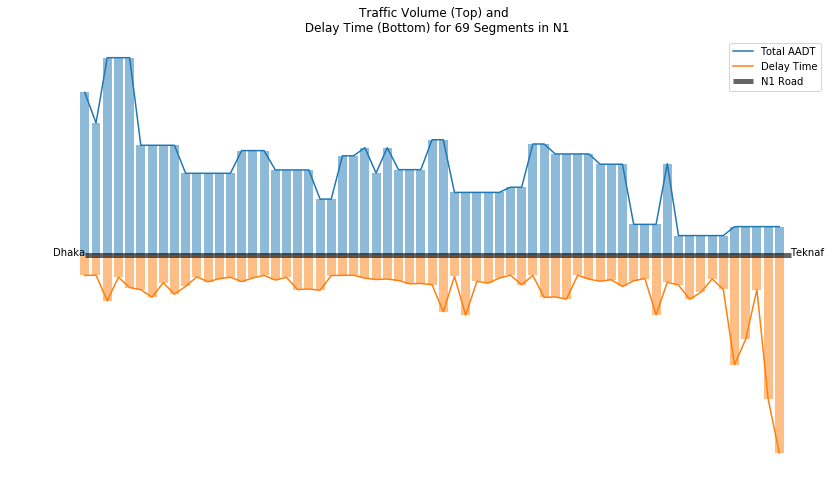

In [14]:
plt.figure(figsize = (14, 8))
plt.title("Traffic Volume (Top) and \n Delay Time (Bottom) for 69 Segments in N1")

x = range(len(df))
y1 = df["Total AADT"]
y2 = -df["Delay Time"]
y = list([y1, y2])

for i in range(2):
    plt.bar(x, y[i], alpha = 0.5)
    plt.plot(x, y[i])

plt.hlines(y = 0, xmin = 0,
           xmax = x[-1]+1,
           label = "N1 Road",
           color = "black", lw = 5, alpha = .6)

plt.text(0,0, "Dhaka", horizontalalignment='right')
plt.text(x[-1]+1, 0, "Teknaf", horizontalalignment='left')

# plt.yticks([-1,0,1])

plt.axis("off")
plt.legend()

In [15]:
# given that majority of C and D bridges are distributed Chittagong ~ Teknaf, it will skew the data too much!
# Thus, log-scale data is used to make 

In [16]:
df = df_tr[["Total AADT","Delay Time"]]

In [17]:
# Log Scale
df = df_tr[["Total AADT","Delay Time"]]
cols = df.columns
df = scale.fit_transform(np.log(df))
df = pd.DataFrame(data = df, columns = cols)
df["Section"] = df_tr["Section"]
df.head()

,Total AADT,Delay Time,Section
0,0.905027,0.262180,2
1,0.805408,0.100000,3
2,1.000000,0.762123,5
3,1.000000,0.456810,6
4,1.000000,0.673744,7


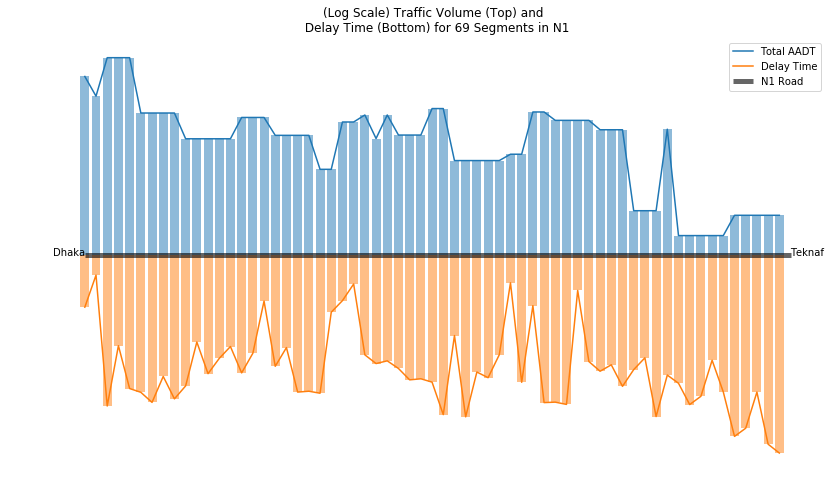

In [18]:
plt.figure(figsize = (14, 8))
plt.title("(Log Scale) Traffic Volume (Top) and \n Delay Time (Bottom) for 69 Segments in N1")

x = range(len(df))
y1 = df["Total AADT"]
y2 = -df["Delay Time"]
y = list([y1, y2])

for i in range(2):
    plt.bar(x, y[i], alpha = 0.5)
    plt.plot(x, y[i])

plt.hlines(y = 0, xmin = 0,
           xmax = x[-1]+1,
           label = "N1 Road",
           color = "black", lw = 5, alpha = .6)

plt.text(0,0, "Dhaka", horizontalalignment='right')
plt.text(x[-1]+1, 0, "Teknaf", horizontalalignment='left')

# plt.yticks([-1,0,1])

plt.axis("off")
plt.legend()

## Plotly

In [19]:
import plotly
from plotly.offline import init_notebook_mode, iplot, plot, download_plotlyjs
init_notebook_mode(connected=True)

from plotly.graph_objs import Layout, Bar, Marker, Figure, Scatter, YAxis, XAxis

In [20]:
df.head()

,Total AADT,Delay Time,Section
0,0.905027,0.262180,2
1,0.805408,0.100000,3
2,1.000000,0.762123,5
3,1.000000,0.456810,6
4,1.000000,0.673744,7


In [21]:
df_tr["Link No"] = df_tr["Link No"].apply(lambda x: x.strip("L"))

In [22]:
import plotly
from plotly.offline import init_notebook_mode, iplot, plot, download_plotlyjs
init_notebook_mode(connected=True)

from plotly.graph_objs import (Layout, Bar, Marker, Figure, Scatter, YAxis, XAxis)
from IPython.html.widgets import interact

def show_graph(criticallity):
    # define data
    y1_data = df["Total AADT"]
    y2_data = df["Delay Time"]
    x_data = df["Section"].astype(str).apply(lambda x: "".join(["Sec_", x]))
    
    # define weight of slider
    y1 = pd.Series([i*criticallity/10 for i in y1_data])    
    y2 = pd.Series([i*(1 - criticallity/10) for i in y2_data])
    
    # highlight top 10 segments
    s = (y1 + y2).sort_values(ascending = False)
    idx = s.index[:10]
    s = pd.DataFrame(s)
    s["width"] = 0
    s.iloc[:10, 1] = 3.0
    s.sort_index(inplace = True)
    
    # print table
    print(df_tr.loc[(y1 + y2).sort_values().tail(10).index].set_index("Section").sort_index()[["Link No",
                                                                                               "Total AADT",
                                                                                               "Delay Time",
                                                                                               "A_num",
                                                                                               "B_num",
                                                                                               "C_num",
                                                                                               "D_num"]])
    
    trace1 = Bar(x = x_data, y = y1, name = 'criticallity',
                marker = Marker(line = dict(color = "black", width = s["width"])))
    trace2 = Bar(x = x_data, y = y2, name = 'vulnerability',
                 marker = Marker(line = dict(color = "black", width = s["width"]),
                                ),
                )
    
    title = 'Top 10 Road Segments with High Criticality and Vulnerability'
    data = [trace1,trace2]
    layout = Layout(
        title = title,
        width = 1000,
        height = 500,
        barmode = 'stack',
        yaxis = YAxis(range = [0,1])
    )
    fig = Figure(data=data,layout=layout)
    iplot(fig)

interact(show_graph, criticallity=(0,10))

C:\Anaconda3\lib\site-packages\IPython\html.py:14: ShimWarning:

The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.



interactive(children=(IntSlider(value=5, description='criticallity', max=10), Output()), _dom_classes=('widget-interact',))

<function __main__.show_graph>